# Regression predictions

TODO: use some sort of regression model to predict future changes in neutrophil count. Maybe the delta neutrophil count? The neutrophil count immediately after treatment?

TODO: should we use a hierarchical Bayesian model?

TODO: Maybe we could start by using a very simple naive regression model for patients... regressing solely on current neutrophil count, treatment duration, and time?

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

from new_patient_model import extract_data_from_tables_new

## Load data

In [2]:
blood_counts = pd.read_excel('../patient_data_venex/Ven_blood_counts_16042023.xlsx', sheet_name='Blood_counts')
bm_blasts = pd.read_excel('../patient_data_venex/Ven_blood_counts_16042023.xlsx', sheet_name='Bone_marrow_blasts')
cycle_days = pd.read_excel('../patient_data_venex/Ven_blood_counts_16042023.xlsx', sheet_name='Cycle_days')

patient_data = pd.read_csv('../patient_data_venex/ven_responses_052023.txt', sep='\t')

In [3]:
patient_ids = blood_counts['Pseudonym'].unique()

## Generate deltas

Predict the change from one time point to the next.

Parameters: prev_neut, prev_blast (interpolated), time_treatment, time_no_treatment, ven_dose

(only use venetoclax treatment)

In [4]:
all_patient_deltas = []
patient_deltas = {}

In [5]:
for patient_id in patient_ids:
    cycle_info, leuk_table, blast_table = extract_data_from_tables_new(blood_counts,
                                                        bm_blasts, cycle_days, patient_id, use_neut=True)
    if len(leuk_table) <= 2 or len(blast_table) <= 2:
        continue
    # list of: (prev_neut, days_in_treatment, days_not_in_treatment, dose, prev_interp_blast, current_neut)
    # TODO: should days_not_in_treatment include the total non-treatment days in the interval, or include the 
    patient_x = []

    # interpolating blasts
    bm_blast_interpolator = scipy.interpolate.PchipInterpolator(blast_table['days_from_bm'], blast_table['bm_blasts'])
    lab_results_matched = leuk_table[leuk_table.days_lab <= blast_table.days_from_bm.max()].copy()
    bm_blasts_interpolated = bm_blast_interpolator(lab_results_matched['days_lab'])
    lab_results_matched['bm_blasts_interpolated'] = bm_blasts_interpolated
    
    # calculating time since end of treatment
    last_row = None
    for i, row in lab_results_matched.iterrows():
        past_cycles = cycle_info[(cycle_info['days_ven_start'] < row['days_lab'])].sort_values('days_ven_stop')
        if last_row is not None:
            last_neut_time = last_row.days_lab
            # is there a treatment that ends before the current time and after the last time?
            past_cycles = past_cycles[past_cycles['days_ven_stop'] >= last_neut_time]
            days_in_treatment = 0
            days_not_in_treatment = row.days_lab - last_neut_time
            dose = 0
            if len(past_cycles) > 0:
                past_cycles = past_cycles.reset_index()
                last_cycle = past_cycles.iloc[-1]
                last_end_date = last_cycle.days_ven_stop
                last_start_date = last_cycle.days_ven_start
                # basically this is how much the treatment interval and measurement interval overlap.
                # if the treatment cycle starts during the interval
                if last_start_date >= last_neut_time:
                    if last_end_date > row.days_lab:
                        days_in_treatment = row.days_lab - last_start_date
                        dose = last_cycle.venetoclax_dose_mg/400
                    else:
                        days_in_treatment = last_end_date - last_start_date
                # if the treatment cycle starts before the interval
                else:
                    if last_end_date > row.days_lab:
                        days_in_treatment = row.days_lab - last_neut_time
                        dose = last_cycle.venetoclax_dose_mg/400
                    else:
                        days_in_treatment = last_end_date - last_neut_time
                days_not_in_treatment = days_not_in_treatment - days_in_treatment
            else:
                pass
            patient_x.append((last_row.b_neut,
                              days_in_treatment, days_not_in_treatment,
                              dose, last_row.bm_blasts_interpolated,
                              row.b_neut))
        last_row = row
    patient_deltas[patient_id] = patient_x
    all_patient_deltas += patient_x

In [6]:
patient_deltas[3360]

[(0.03, 0, 1.0, 0, 80.0, 0.02),
 (0.02, 27, 0.0, 0, 76.93760110182988, 0.01),
 (0.01, 0.0, 15.0, 0, 5.347888795559381, 0.71),
 (0.71, 20, 8.0, 0, 2.5, 0.12),
 (0.12, 0, 14.0, 0, 2.5, 2.34),
 (2.34, 20, 8.0, 0, 2.5, 0.27),
 (0.27, 0, 11.0, 0, 2.5, 1.14),
 (1.14, 13, 15.0, 0, 2.5, 0.14),
 (0.14, 0, 14.0, 0, 2.5, 1.26),
 (1.26, 13, 15.0, 0, 2.5, 0.06),
 (0.06, 0, 11.0, 0, 2.5, 0.75),
 (0.75, 13, 15.0, 0, 2.5, 0.1),
 (0.1, 0, 14.0, 0, 2.5, 0.52),
 (0.52, 20, 8.0, 0, 2.5, 0.1),
 (0.1, 0, 21.0, 0, 2.5, 0.25),
 (0.25, 20, 8.0, 0, 4.324966238761668, 0.05),
 (0.05, 0, 24.0, 0, 11.331413593079814, 0.06)]

## Regression for every patient, no train/test split

In [7]:
import statsmodels.api as sm


In [8]:
all_patient_results = {}
all_r2 = {}
all_patient_results_table = {}

In [9]:
for patient_id in patient_ids:
    try:
        data = pd.DataFrame(patient_deltas[patient_id])
        if len(data) < 6:
            continue
        data.columns = ['prev_neut', 'days_in_treatment', 'days_not_in_treatment', 'dose', 'prev_interp_blast', 'current_neut']
        X = data.iloc[:,:-1]
        y = data.iloc[:, -1:]
        X = sm.add_constant(X)
        model = sm.OLS(y, X)
        results = model.fit()
        all_patient_results[patient_id] = results
        all_r2[patient_id] = results.rsquared
        rmse = np.sqrt(results.mse_total)
        # for merging data into stuff...
        results_table = {'blasts_train': np.inf, 'leuk_train': rmse,
                         'neut_corr': np.sqrt(results.rsquared), 'blast_corr': 0,
                         'neut_mape': 0,
                         'neutropenia_balanced_accuracy': 0, 'neutropenia_f1': 0,
                         'neutropenia_accuracy': 0, 
                         'neut_corr_2': results.rsquared, 'blast_corr_2': 0,
                         'neut_fvu_r2': 1 - results.rsquared,
                         'blast_fvu_r2': 1, 'frac_unexplained_variance_neut': 1 - results.rsquared,
                         'frac_unexplained_variance_blast': 1,
                         'model': 'reg6'}
        all_patient_results_table[patient_id] = results_table
    except:
        continue

In [10]:
all_patient_results_table = pd.DataFrame(all_patient_results_table).T

In [11]:
fvu = np.array([1 - x for x in all_r2.values()])

In [12]:
fvu.mean()

0.5482726332282462

In [13]:
np.median(fvu)

0.5749482537536883

{'whiskers': [<matplotlib.lines.Line2D at 0x7f6ab36944f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f6ab3694a30>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f6ab3694250>],
 'medians': [<matplotlib.lines.Line2D at 0x7f6ab3694f70>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f6ab3695210>],
 'means': []}

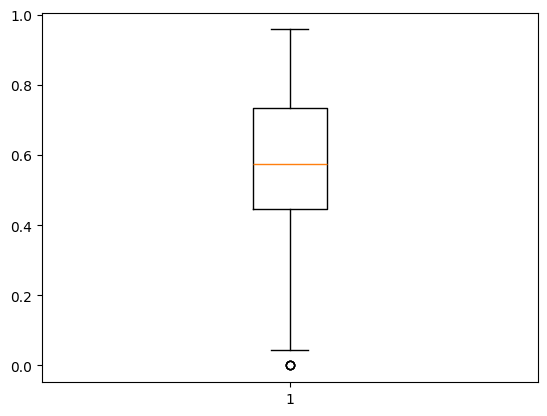

In [14]:
plt.boxplot(fvu)

## Compare with ODE models

In [15]:
rmse_data_combined = pd.read_csv('rmse_data_combined_table_2025_05_01.csv', index_col=0)

### Merge table with rmse_data_combined

In [16]:
rmse_data_combined = pd.concat([rmse_data_combined, all_patient_results_table])

### Plotting boxplots for FVU

In [17]:
model_subset = ['m2c', 'reg6']
rmse_data_subset = rmse_data_combined[rmse_data_combined.model.isin(model_subset)]

Text(0.5, 0.98, '')

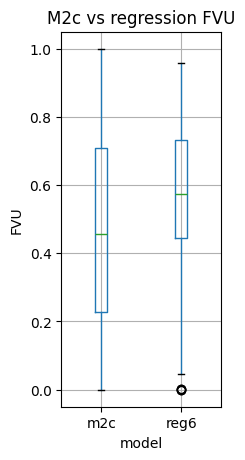

In [18]:
fig, ax = plt.subplots(figsize=(2, 5))
ax = rmse_data_subset.boxplot('neut_fvu_r2', by='model', ax=ax)
ax.set_ylabel('FVU')
ax.set_title('M2c vs regression FVU')
#ax.set_ylim(0, 2)
fig = ax.get_figure()
fig.suptitle('')

### Plotting boxplots for RMSE

Text(0.5, 0.98, '')

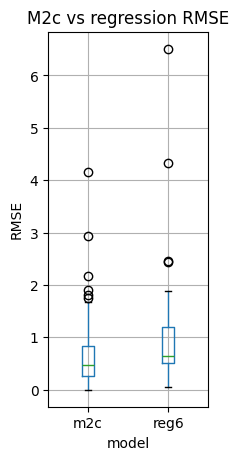

In [19]:
fig, ax = plt.subplots(figsize=(2, 5))
ax = rmse_data_subset.boxplot('leuk_train', by='model', ax=ax)
ax.set_ylabel('RMSE')
ax.set_title('M2c vs regression RMSE')
#ax.set_ylim(0, 2)
fig = ax.get_figure()
fig.suptitle('')

Text(0.5, 0.98, '')

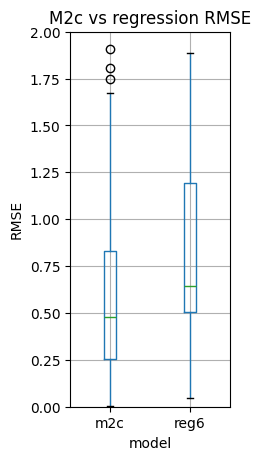

In [20]:
fig, ax = plt.subplots(figsize=(2, 5))
ax = rmse_data_subset.boxplot('leuk_train', by='model', ax=ax)
ax.set_ylabel('RMSE')
ax.set_title('M2c vs regression RMSE')
ax.set_ylim(0, 2)
fig = ax.get_figure()
fig.suptitle('')

### Wilcoxon test P-values for FVU and RMSE

In [21]:
m2c_data = rmse_data_subset.query('model=="m2c"')
reg6_data = rmse_data_subset.query('model=="reg6"')
overlapping_indices = m2c_data.index.intersection(reg6_data.index)

In [22]:
stat, pval = scipy.stats.wilcoxon(m2c_data.loc[overlapping_indices].neut_fvu_r2,
                                  reg6_data.loc[overlapping_indices].neut_fvu_r2, nan_policy='omit')

In [23]:
stat, pval

(739.0, 0.012466444790568954)

In [24]:
scipy.stats.wilcoxon(m2c_data.loc[overlapping_indices].leuk_train,
                     reg6_data.loc[overlapping_indices].leuk_train, nan_policy='omit')

WilcoxonResult(statistic=315.0, pvalue=2.643525012706306e-07)

## Train-test split per patient

We will train the regression model on data from the first 5 cycles, and test on the subsequent cycles.

In [25]:
m2c_train_test_rmse_data = pd.read_csv('../systematic_comparison_results_simplified_models/m2c_train_test_rmse_all_data.csv', index_col=0)

In [26]:
new_index = m2c_train_test_rmse_data.index.map(lambda x: x.split('_'))
m2c_test_subset = m2c_train_test_rmse_data[m2c_train_test_rmse_data.index.map(lambda x: x[-1]=='5')]

In [27]:
m2c_test_subset.index = m2c_test_subset.index.map(lambda x: int(x.split('_')[0]))

In [28]:
patient_ids = m2c_test_subset.index

In [29]:
from new_patient_model import split_cycles

In [30]:
# load data
all_patients_train_data = {}
all_patients_test_data = {}
all_patients_additional_data = {}
for patient_id in patient_ids:
    cycle_info, leuk_table, blast_table = extract_data_from_tables_new(blood_counts,
                                                        bm_blasts, cycle_days, patient_id, use_neut=True)

    if len(leuk_table) <= 2 or len(blast_table) <= 2:
        continue
    # list of: (prev_neut, days_in_treatment, days_not_in_treatment, dose, prev_interp_blast, current_neut)
    # TODO: should days_not_in_treatment include the total non-treatment days in the interval, or include the 
    patient_train = []
    patient_test = []
    patient_additional = []

    # interpolating blasts
    bm_blast_interpolator = scipy.interpolate.PchipInterpolator(blast_table['days_from_bm'], blast_table['bm_blasts'])
    lab_results_matched = leuk_table[leuk_table.days_lab <= blast_table.days_from_bm.max()].copy()
    bm_blasts_interpolated = bm_blast_interpolator(lab_results_matched['days_lab'])
    lab_results_matched['bm_blasts_interpolated'] = bm_blasts_interpolated

    leuk_train, leuk_test, blast_train, blast_test, leuk_rem, blast_rem = split_cycles(lab_results_matched,
                                                                                       blast_table,
                                                                                       cycle_info,
                                                             n_cycles_train=5, n_cycles_test=2)
    if len(leuk_test) == 0:
        print(f'Patient {patient_id}: lack of test data')
        print(len(leuk_table), len(lab_results_matched))
        continue
    # calculating time since end of treatment
    last_row = None
    i = 0
    table_index = 0
    # figure out if we're in the train, test, or additional tables
    current_table = leuk_train.copy().reset_index()
    status = 'train'
    while i < lab_results_matched.shape[0]:
        row = current_table.loc[table_index]
        past_cycles = cycle_info[(cycle_info['days_ven_start'] < row['days_lab'])].sort_values('days_ven_stop')
        if last_row is not None:
            last_neut_time = last_row.days_lab
            # is there a treatment that ends before the current time and after the last time?
            past_cycles = past_cycles[past_cycles['days_ven_stop'] >= last_neut_time]
            days_in_treatment = 0
            days_not_in_treatment = row.days_lab - last_neut_time
            dose = 0
            if len(past_cycles) > 0:
                past_cycles = past_cycles.reset_index()
                last_cycle = past_cycles.iloc[-1]
                last_end_date = last_cycle.days_ven_stop
                last_start_date = last_cycle.days_ven_start
                # basically this is how much the treatment interval and measurement interval overlap.
                # if the treatment cycle starts during the interval
                if last_start_date >= last_neut_time:
                    if last_end_date > row.days_lab:
                        days_in_treatment = row.days_lab - last_start_date
                        dose = last_cycle.venetoclax_dose_mg/400
                    else:
                        days_in_treatment = last_end_date - last_start_date
                # if the treatment cycle starts before the interval
                else:
                    if last_end_date > row.days_lab:
                        days_in_treatment = row.days_lab - last_neut_time
                        dose = last_cycle.venetoclax_dose_mg/400
                    else:
                        days_in_treatment = last_end_date - last_neut_time
                days_not_in_treatment = days_not_in_treatment - days_in_treatment
            else:
                pass
            new_x = (last_row.b_neut,
                              days_in_treatment, days_not_in_treatment,
                              dose, last_row.bm_blasts_interpolated,
                              row.b_neut)
            if status == 'train':
                patient_train.append(new_x)
            elif status == 'test':
                patient_test.append(new_x)
            elif status == 'additional':
                patient_additional.append(new_x)
        i += 1
        table_index += 1
        if i >= len(leuk_train) and status == 'train':
            status = 'test'
            current_table = leuk_test.reset_index()
            table_index = 0
        elif i >= len(leuk_train) + len(leuk_test) and status == 'test':
            status = 'additional'
            current_table = leuk_rem.reset_index()
            table_index = 0
        last_row = row
    all_patients_train_data[patient_id] = patient_train
    all_patients_test_data[patient_id] = patient_test
    all_patients_additional_data[patient_id] = patient_additional

## Test regression for train-test split

In [31]:
from sklearn.metrics import mean_squared_error

In [32]:
data_train = pd.DataFrame(all_patients_train_data[patient_id])

In [33]:
data_train = pd.DataFrame(all_patients_train_data[patient_id])
data_train.columns = ['prev_neut', 'days_in_treatment', 'days_not_in_treatment', 'dose', 'prev_interp_blast', 'current_neut']
X = data_train.iloc[:,:-1]
y = data_train.iloc[:, -1:]
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

data_test = pd.DataFrame(all_patients_test_data[patient_id])
data_test.columns = ['prev_neut', 'days_in_treatment', 'days_not_in_treatment', 'dose', 'prev_interp_blast', 'current_neut']
X_test = data_test.iloc[:,:-1]
y_test = data_test.iloc[:, -1:].to_numpy().flatten()
X_test = sm.add_constant(X_test, has_constant='add')
y_predict_test = model.predict(results.params, exog=X_test)
r, pv = scipy.stats.pearsonr(y_test, y_predict_test)
rmse = np.sqrt(mean_squared_error(y_test, y_predict_test))

data_add = pd.DataFrame(all_patients_additional_data[patient_id])
data_add.columns = ['prev_neut', 'days_in_treatment', 'days_not_in_treatment', 'dose', 'prev_interp_blast', 'current_neut']
X_test = data_add.iloc[:,:-1]
y_test = data_add.iloc[:, -1:].to_numpy().flatten()
X_test = sm.add_constant(X_test, has_constant='add')
y_predict_test = model.predict(results.params, exog=X_test)
r, pv = scipy.stats.pearsonr(y_test, y_predict_test)
rmse = np.sqrt(mean_squared_error(y_test, y_predict_test))

In [34]:
all_patient_train_results = {}
all_train_r2 = {}
all_patient_train_results_table = {}

all_test_r2 = {}
all_patient_test_results_table = {}

all_additional_r2 = {}
all_patient_additional_results_table = {}

In [35]:
for patient_id in patient_ids:
    try:
        data_train = pd.DataFrame(all_patients_train_data[patient_id])
        data_train.columns = ['prev_neut', 'days_in_treatment', 'days_not_in_treatment', 'dose', 'prev_interp_blast', 'current_neut']
        X = data_train.iloc[:,:-1]
        y = data_train.iloc[:, -1:]
        X = sm.add_constant(X)
        model = sm.OLS(y, X)
        results = model.fit()
        all_patient_train_results[patient_id] = results
        all_train_r2[patient_id] = results.rsquared
        rmse = np.sqrt(results.mse_total)
        # for merging data into stuff...
        train_results_table = {'blasts_train': np.inf, 'leuk_train': rmse,
                         'neut_corr': np.sqrt(results.rsquared), 'blast_corr': 0,
                         'neut_corr_2': results.rsquared, 'blast_corr_2': 0,
                         'neut_fvu_r2': 1 - results.rsquared,
                         'blast_fvu_r2': 1, 'frac_unexplained_variance_neut': 1 - results.rsquared,
                         'frac_unexplained_variance_blast': 1,
                         'model': 'reg6'}
        all_patient_train_results_table[patient_id] = train_results_table

        # TODO: run test/additional
        data_test = pd.DataFrame(all_patients_test_data[patient_id])
        data_test.columns = ['prev_neut', 'days_in_treatment', 'days_not_in_treatment', 'dose', 'prev_interp_blast', 'current_neut']
        X_test = data_test.iloc[:,:-1]
        y_test = data_test.iloc[:, -1:].to_numpy().flatten()
        X_test = sm.add_constant(X_test, has_constant='add')
        y_predict_test = model.predict(results.params, exog=X_test)
        r, pv = scipy.stats.pearsonr(y_test, y_predict_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_predict_test))
        test_results_table = {'blasts_train': np.inf, 'leuk_train': rmse,
                         'neut_corr': r, 'blast_corr': 0,
                         'neut_corr_2': r**2, 'blast_corr_2': 0,
                         'neut_fvu_r2': 1 - r**2,
                         'blast_fvu_r2': 1, 'frac_unexplained_variance_neut': 1 - r**2,
                         'frac_unexplained_variance_blast': 1,
                         'model': 'reg6'}
        all_patient_test_results_table[patient_id] = test_results_table
        
        data_add = pd.DataFrame(all_patients_additional_data[patient_id])
        data_add.columns = ['prev_neut', 'days_in_treatment', 'days_not_in_treatment', 'dose', 'prev_interp_blast', 'current_neut']
        X_test = data_add.iloc[:,:-1]
        y_test = data_add.iloc[:, -1:].to_numpy().flatten()
        X_test = sm.add_constant(X_test, has_constant='add')
        y_predict_test = model.predict(results.params, exog=X_test)
        r, pv = scipy.stats.pearsonr(y_test, y_predict_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_predict_test))
        additional_results_table = {'blasts_train': np.inf, 'leuk_train': rmse,
                         'neut_corr': r, 'blast_corr': 0,
                         'neut_corr_2': r**2, 'blast_corr_2': 0,
                         'neut_fvu_r2': 1 - r**2,
                         'blast_fvu_r2': 1, 'frac_unexplained_variance_neut': 1 - r**2,
                         'frac_unexplained_variance_blast': 1,
                         'model': 'reg6'}
        all_patient_additional_results_table[patient_id] = additional_results_table
    except Exception as e:
        print(patient_id, 'Error', e)

3841 Error Length mismatch: Expected axis has 0 elements, new values have 6 elements
8205 Error x and y must have length at least 2.
1978 Error x and y must have length at least 2.


In [36]:
all_patient_train_results_table = pd.DataFrame(all_patient_train_results_table).T
all_patient_test_results_table = pd.DataFrame(all_patient_test_results_table).T
all_patient_additional_results_table = pd.DataFrame(all_patient_additional_results_table).T

## Comparing train/test with M2c

In [37]:
patient_cycle_train_table = pd.read_csv('patient_cycle_train_table.csv', index_col=0)
patient_cycle_test_table = pd.read_csv('patient_cycle_test_table.csv', index_col=0)
patient_cycle_additional_table = pd.read_csv('patient_cycle_additional_table.csv', index_col=0)

In [38]:
patient_train_table_combined = pd.DataFrame([patient_cycle_train_table.loc[:, '5'],
                                             all_patient_train_results_table.loc[:, 'leuk_train']]).T
patient_train_table_combined.columns = ['m2c', 'reg6']
patient_test_table_combined = pd.DataFrame([patient_cycle_test_table.loc[:, '5'],
                                             all_patient_test_results_table.loc[:, 'leuk_train']]).T
patient_test_table_combined.columns = ['m2c', 'reg6']

patient_additional_table_combined = pd.DataFrame([patient_cycle_additional_table.loc[:, '5'],
                                             all_patient_additional_results_table.loc[:, 'leuk_train']]).T
patient_additional_table_combined.columns = ['m2c', 'reg6']


In [39]:
# combine the tables
train_data_long = patient_train_table_combined.melt(ignore_index=False)
train_data_long.columns = ['model', 'rmse']
train_data_long['comparison'] = 'train'

test_data_long = patient_test_table_combined.melt(ignore_index=False)
test_data_long.columns = ['model', 'rmse']
test_data_long['comparison'] = 'short-term test'

additional_data_long = patient_additional_table_combined.melt(ignore_index=False)
additional_data_long.columns = ['model', 'rmse']
additional_data_long['comparison'] = 'long-term test'

concatenated_data_long = pd.concat([train_data_long, test_data_long, additional_data_long]).reset_index()

In [40]:
import seaborn as sns

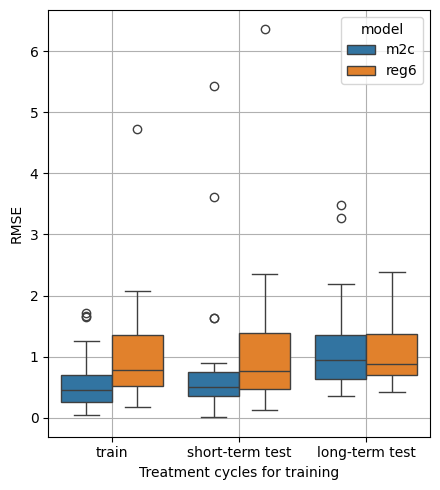

In [43]:
fig, ax = plt.subplots(figsize=(4.5, 5))
ax = sns.boxplot(data=concatenated_data_long, x='comparison', y='rmse', hue='model', ax=ax)
ax.grid()
#ax.set_title('RMSEs for different numbers of training cycles')
ax.set_ylabel('RMSE')
ax.set_xlabel('Treatment cycles for training')
plt.tight_layout()
plt.show()

In [45]:
scipy.stats.wilcoxon(patient_test_table_combined.m2c,
                     patient_test_table_combined.reg6, nan_policy='omit')

WilcoxonResult(statistic=131.0, pvalue=0.011802620720118284)

In [46]:
scipy.stats.wilcoxon(patient_additional_table_combined.m2c,
                     patient_additional_table_combined.reg6, nan_policy='omit')

WilcoxonResult(statistic=211.0, pvalue=0.6701805889606476)

In [47]:
scipy.stats.wilcoxon(patient_train_table_combined.m2c,
                     patient_train_table_combined.reg6, nan_policy='omit')

WilcoxonResult(statistic=1.0, pvalue=4.656612873077393e-10)

The regression model uses the neutrophil and blast counts at the previous time point as an independent variable, which includes the time points after the model fitting ended, which are not used at all in m2c. 